In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.io
from scipy.signal import lfilter,butter
#import seaborn as sns

In [2]:
nic=scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12_FP_mean_denoisedTS.mat')
data = nic['mts'].T
print(data.shape)

(29, 3890)


In [3]:
roinames = nic["roi_names"].flatten()
for name in roinames:
    print(name[0])

ACC
L_Acb
L_Amygdala
L_Amygdala_CM_Juelich50
L_Amygdala_LB_Juelich50_minus_intersect
L_Amygdala_SF_Juelich50
L_Caudate
L_FOrb
L_Hipp
L_Insula
L_MidFG
L_Pallidum
L_Putamen
L_SN_Hammersn30r83_74
L_Thalamus
R_Acb
R_Amygdala
R_Amygdala_CM_Juelich50
R_Amygdala_LB_Juelich50_minus_intersect
R_Amygdala_SF_Juelich50
R_Caudate
R_FOrb
R_Hipp
R_Insula
R_MidFG
R_Pallidum
R_Putamen
R_SN_Hammersn30r83_75
R_Thalamus


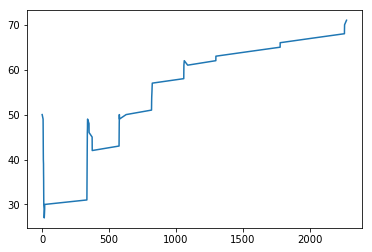

In [4]:
nict = scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12-FP/10-Apr-2017_09-57_LMP_NIC_12_FP.mat')
craving = nict['craveUpdate']
crav_t=(craving[0][0][0].T).flatten()
crav_v=(craving[0][0][1].T).flatten()
plt.plot(crav_t,crav_v)

In [10]:
# create a 10th order Butterworth filter from 0.01 to 0.1 Hz
def butter_bandpass(lowcut,highcut,fs,order=8):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq

    b,a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(data,lowcut,highcut,fs,order=8):
    b,a = butter_bandpass(lowcut,highcut,fs,order=order)
    return lfilter(b,a,data)

sampling_freq = 1/0.802
print(sampling_freq)

1.2468827930174562


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


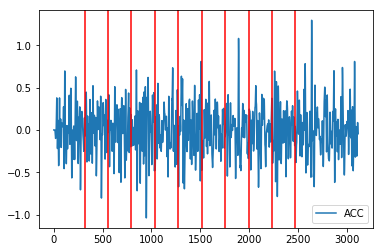

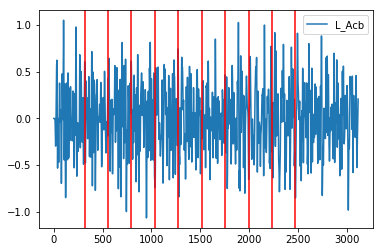

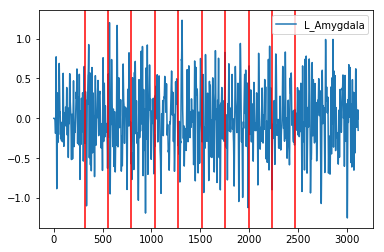

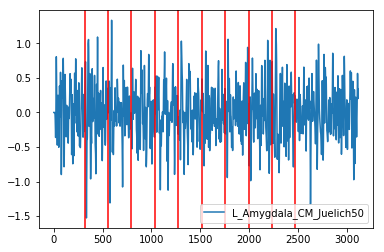

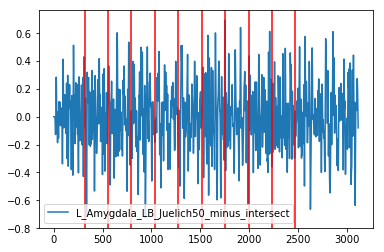

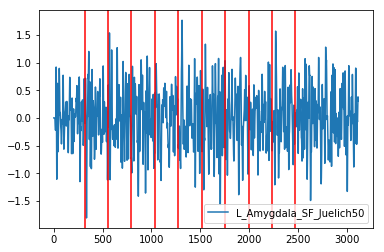

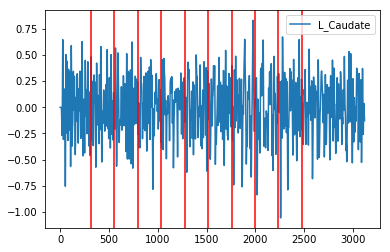

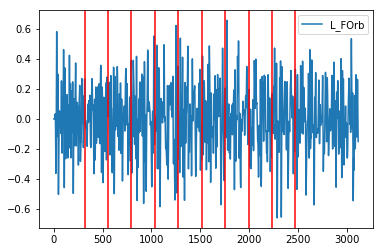

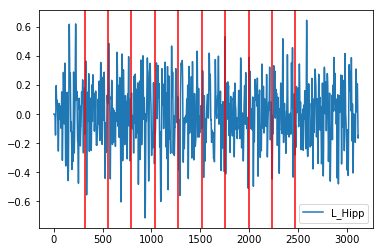

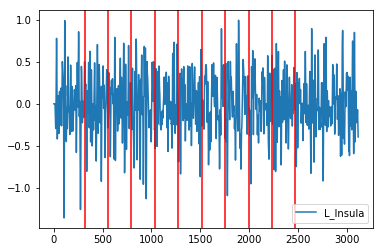

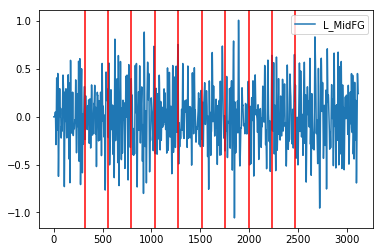

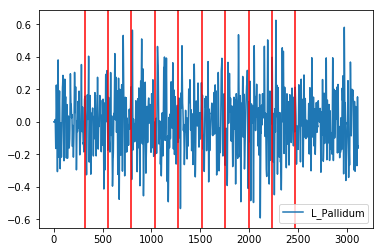

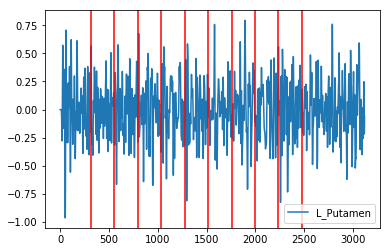

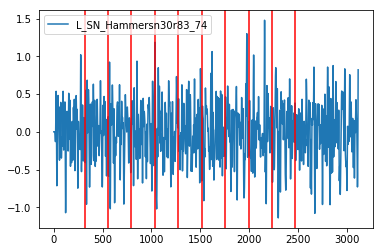

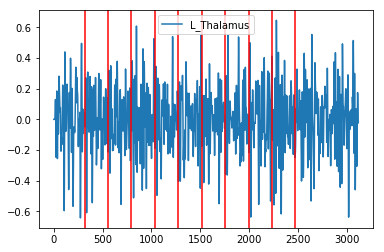

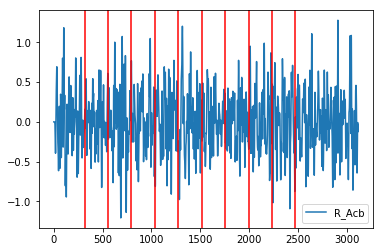

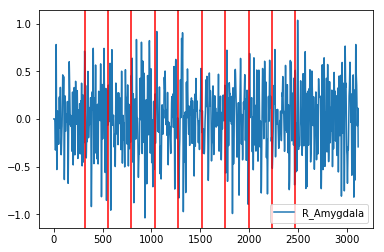

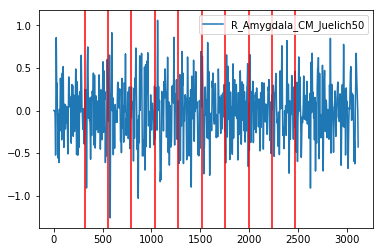

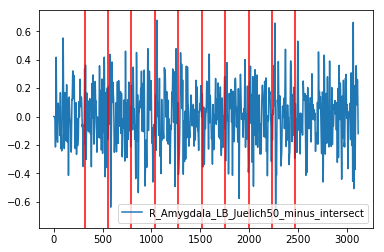

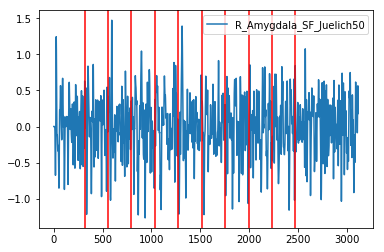

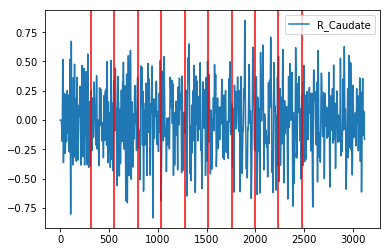

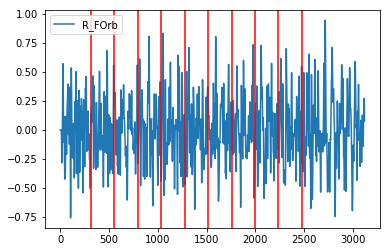

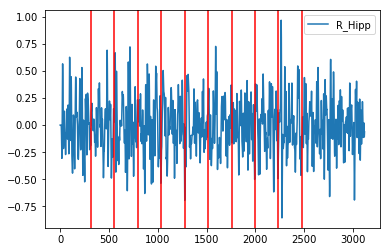

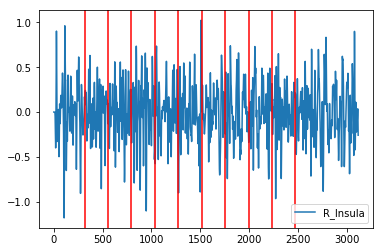

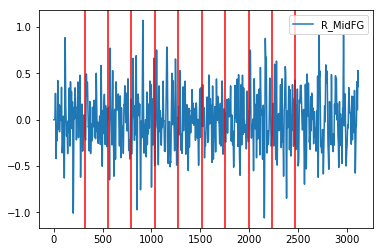

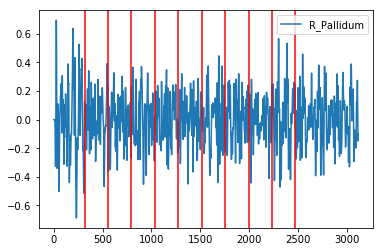

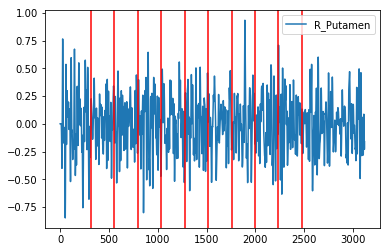

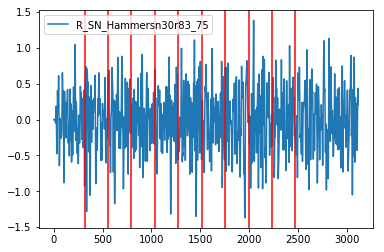

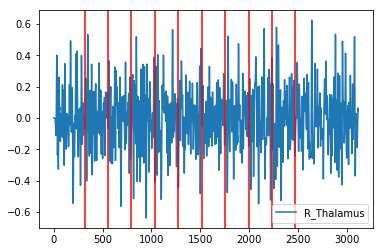

In [16]:
t = np.linspace(0,3889*.802,3890)
puffs=np.arange(316,2500,240)
for trace,name in zip(data,roinames):
    trace_filtered = butter_bandpass_filter(trace,0.01,0.1,sampling_freq,order=7)
    plt.figure()
    plt.plot(t,trace_filtered,label=name[0])
    for p in puffs:
        plt.axvline(x=p,color="r")
    plt.legend()
